# **ANALYSIS AND PLOT RESULTS**

## 1. **SETUP**

### 1.1 Clone the Repository from GitHub

In [1]:
!test -d DLA_LLMSANALYSIS && rm -rf DLA_LLMSANALYSIS
!git clone https://github.com/wakaflocka17/DLA_LLMSANALYSIS.git
%cd DLA_LLMSANALYSIS

Cloning into 'DLA_LLMSANALYSIS'...
remote: Enumerating objects: 577, done.
remote: Counting objects: 100% (276/276), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 577 (delta 175), reused 173 (delta 79), pack-reused 301 (from 1)
Receiving objects: 100% (577/577), 1.42 MiB | 12.52 MiB/s, done.
Resolving deltas: 100% (393/393), done.
/content/DLA_LLMSANALYSIS


## 2. **PLOT RESULTS**

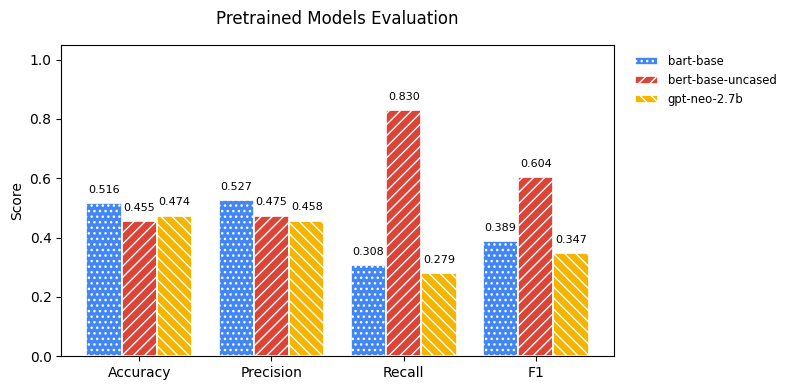

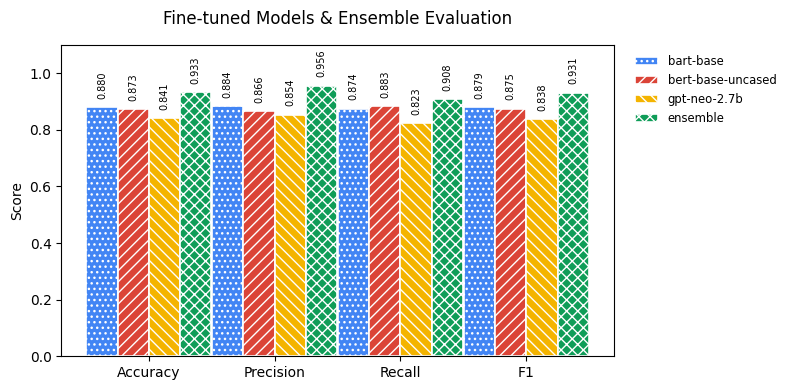

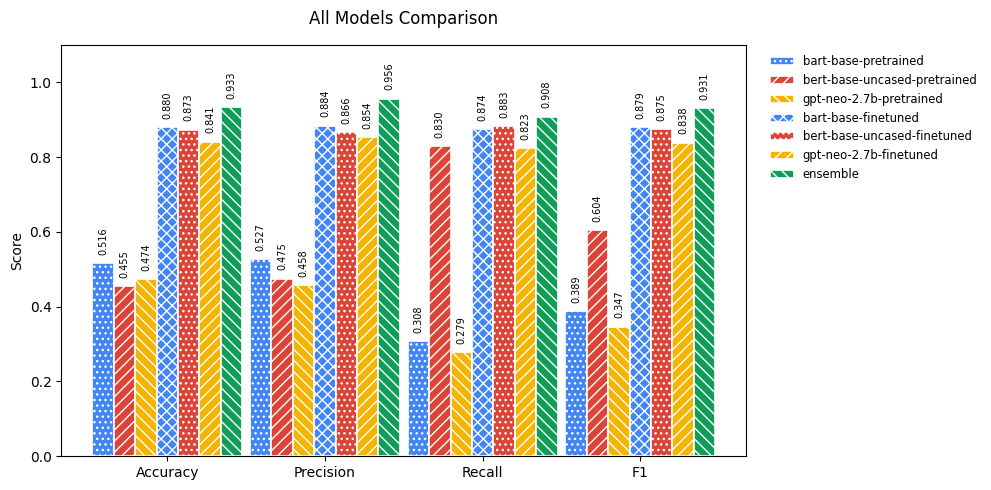

In [8]:
import os, glob, json
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

# 1) Configuration
metrics     = ["accuracy", "precision", "recall", "f1"]
base_dir    = "experiments/results/evaluation"
single_keys = ["bart-base", "bert-base-uncased", "gpt-neo-2.7b"]

# Google palette + white‐edge hatches
colors = {
    "bart-base":         "#4285F4",
    "bert-base-uncased": "#DB4437",
    "gpt-neo-2.7b":      "#F4B400",
    "ensemble":          "#0F9D58",
}
hatches = ['...', '///', '\\\\\\', 'xxx']

# 2) Load data
data = {"pretrained": {}, "finetuned": {}}
for et in data:
    for path in glob.glob(f"{base_dir}/{et}/*-imdb.json"):
        name = os.path.basename(path).replace("-imdb.json","")
        d = json.load(open(path))
        data[et][name] = [d[m] for m in metrics]
ens_files = glob.glob(os.path.join(base_dir, "ensemble-mv-idb-metrics.json"))
if not ens_files:
    raise FileNotFoundError("ensemble JSON not found under finetuned/")
em = json.load(open(ens_files[0]))
data["finetuned"]["ensemble"] = [em[m] for m in metrics]


def plot_group(eval_dict, models, title, out_png,
               width_scale=0.8,
               rotate_labels=False,
               label_fontsize=8,
               label_padding=6,
               ylim_top=1.05):
    fig, ax = plt.subplots(figsize=(8,4))
    x, n = range(len(metrics)), len(models)
    width = width_scale / n

    # bordo nero
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.8)
        spine.set_color("black")

    # barre + hatches
    bars = []
    for i, name in enumerate(models):
        rects = ax.bar(
            [xi + i*width for xi in x],
            eval_dict[name],
            width=width,
            color=colors[name],
            edgecolor="white",
            hatch=hatches[i],
            linewidth=1.2,
            label=name
        )
        bars.append(rects)

    # annotate
    for rects in bars:
        if rotate_labels:
            # per ogni singolo rettangolo, aggiungo un testo manualmente
            for rect in rects:
                h = rect.get_height()
                x_pos = rect.get_x() + rect.get_width()/2
                # trasforma in dati+punti: y offset = label_padding pts
                trans = mtransforms.offset_copy(
                    ax.transData, fig=fig, x=0, y=label_padding, units='points'
                )
                ax.text(
                    x_pos, h, f"{h:.3f}",
                    transform=trans,
                    ha='center', va='bottom',
                    rotation=90,
                    fontsize=label_fontsize
                )
        else:
            ax.bar_label(
                rects,
                fmt="%.3f",
                padding=label_padding,
                fontsize=label_fontsize
            )

    # styling
    ax.set_xticks([xi + width*(n-1)/2 for xi in x])
    ax.set_xticklabels([m.capitalize() for m in metrics])
    ax.set_ylim(0, ylim_top)
    ax.set_ylabel("Score")
    ax.set_title(title, pad=15)

    # legend esterna
    fig.subplots_adjust(right=0.75)
    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0),
              frameon=False, ncol=1, fontsize="small")

    plt.tight_layout()
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()


def plot_group_all(eval_dict, keys, title, out_png,
                   width_scale=0.8,
                   rotate_labels=True,
                   label_fontsize=7,
                   label_padding=6,
                   ylim_top=1.10):
    fig, ax = plt.subplots(figsize=(10,5))
    x, n = range(len(metrics)), len(keys)
    width = width_scale / n

    # bordo nero
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.8)
        spine.set_color("black")

    # barre
    bars = []
    for i, fk in enumerate(keys):
        if fk == "ensemble":
            base = "ensemble"
        elif fk.endswith("-pretrained"):
            base = fk[:-11]
        elif fk.endswith("-finetuned"):
            base = fk[:-10]
        else:
            base = fk

        rects = ax.bar(
            [xi + i*width for xi in x],
            eval_dict[fk],
            width=width,
            color=colors[base],
            edgecolor="white",
            hatch=hatches[i % len(hatches)],
            linewidth=1.2,
            label=fk
        )
        bars.append(rects)

    # annotate
    for rects in bars:
        if rotate_labels:
            for rect in rects:
                h = rect.get_height()
                x_pos = rect.get_x() + rect.get_width()/2
                trans = mtransforms.offset_copy(
                    ax.transData, fig=fig, x=0, y=label_padding, units='points'
                )
                ax.text(
                    x_pos, h, f"{h:.3f}",
                    transform=trans,
                    ha='center', va='bottom',
                    rotation=90,
                    fontsize=label_fontsize
                )
        else:
            ax.bar_label(
                rects,
                fmt="%.3f",
                padding=2,
                fontsize=label_fontsize
            )

    # styling
    ax.set_xticks([xi + width*(n-1)/2 for xi in x])
    ax.set_xticklabels([m.capitalize() for m in metrics])
    ax.set_ylim(0, ylim_top)
    ax.set_ylabel("Score")
    ax.set_title(title, pad=15)

    fig.subplots_adjust(right=0.75)
    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0),
              frameon=False, ncol=1, fontsize="small")

    plt.tight_layout()
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()


# 5) Generate all three plots

# a) pretrained: etichette orizzontali
plot_group(
    data["pretrained"], single_keys,
    "Pretrained Models Evaluation",
    "pretrained_evaluation.png"
)

# b) fine‐tuned + ensemble: ruotate, con offset in punti
plot_group(
    data["finetuned"], single_keys + ["ensemble"],
    "Fine-tuned Models & Ensemble Evaluation",
    "finetuned_plus_ensemble.png",
    width_scale=0.99,
    rotate_labels=True,
    label_fontsize=7,
    label_padding=6,
    ylim_top=1.10
)

# c) all models: stesso schema del secondo
all_keys = [f"{k}-pretrained" for k in single_keys] + \
           [f"{k}-finetuned" for k in single_keys] + \
           ["ensemble"]
all_data = {
    **{f"{k}-pretrained": data["pretrained"][k] for k in single_keys},
    **{f"{k}-finetuned":  data["finetuned"][k]  for k in single_keys},
    "ensemble": data["finetuned"]["ensemble"]
}

plot_group_all(
    all_data, all_keys,
    "All Models Comparison",
    "all_models_comparison.png",
    width_scale=0.95,
    rotate_labels=True,
    label_fontsize=7,
    label_padding=6,
    ylim_top=1.10
)